<a href="https://colab.research.google.com/github/januverma/transformers-stuff/blob/main/warmup_schedulers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Warm-up Schedulers
**Janu Verma**
j.verma5@gmail.com

Training deep neural networks is achieve best performance is no small task. Many knobs needs to be adjusted properly for the training to proceed smoothly, often this tuning needs to be performed during the training process. An important aspect of the neural network training is the choice of the learning rate, which can have a big effect of the model training. Furthermore, the learning rate is typically varied alongwith the training process which is governed by a chosen schedule. The choice of this schedule also has a large impact on the quality of training.
A wide variety of learning rate schedulers have beedn developed which adjust the learning rate based on the number of training epochs e.g. `step-scheduler` decays the learning rate of each parameter group by a fixed factor every `k` epochs. Other choices use various functions like constant, linear, exponential, cosine etc. to decay the learning rates. These schedulers have been shown experically to achieve best performances for various benchmarks, and the choice of a schedular is usually dependent on the task. For an excellent exposition on learning rate schedulers, refer to [The Best Learning Rate Schedules](https://cameronrwolfe.substack.com/p/the-best-learning-rate-schedules) by [Cameron Wolfe](https://twitter.com/cwolferesearch).

## **Learning rate warm-up** 
In this notebook, we will focus on training transformers which have garnared a lot of focus recently owing to the success of `GPT3.5` and `ChatGPT`. It is notoriously difficult to train deep transformer models. In the original paper, Attention is all you need, the authors adapted multiple tricks to achieve stable training. One such choices was to use warm-up learning rate schedulers where the learning rate is gradually increased from 0 to the specified learning rate in first few epochs. Thus, the learning is allowed to 'warm-up` initially by taking small steps, instead of jumping in large steps from the onset.  

Warm-up is not required for most neural networks, but has been indespensable for transformer models. Training can diverge if we just start with a learning rate without warming it up. Also using a very small learning rate throughout the training is impractical as it would take a long time. It is quite puzzling to understand the requirement of warm-up for transformers. Some works [Liu et al](https://arxiv.org/pdf/1908.03265.pdf) and [Huang et al](https://www.cs.toronto.edu/~mvolkovs/ICML2020_tfixup.pdf) explored this phenomenon and observed that:
  - Adam uses the bias correction factors, and different learning rates for different parameters which can lead to a higher variance Adam updates during the first iterations.
  - Iteratively applied Layer Normalization across layers can lead to very high gradients during the first iterations.

For a detailed exposition on the interplay of Adam, LayerNorm, and LR, check out [this post](https://www.borealisai.com/research-blogs/tutorial-17-transformers-iii-training/) by [BorealisAI](https://www.borealisai.com). 

There are some techniques which can mitigate the problems of transformer training without the use of warm-up scheduler. Nevertheless, warm-up with Adam is still a popular method to train transformer models, because warm-up is a simple, yet effective way of solving the gradient problem in the first iterations. 

 In the following, we will implement warm-up for schedulers and study their behaviour. 

In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam, AdamW

Let's start with a parameter tensor which will use for our experiments.

In [2]:
p = nn.Parameter(torch.empty(4, 4))
p

Parameter containing:
tensor([[-5.3297e-36,  4.5764e-41, -5.3297e-36,  4.5764e-41],
        [-5.3298e-36,  4.5764e-41, -5.3298e-36,  4.5764e-41],
        [-5.3298e-36,  4.5764e-41, -5.3298e-36,  4.5764e-41],
        [-5.3299e-36,  4.5764e-41, -4.8997e-19,  4.5764e-41]],
       requires_grad=True)

In [3]:
p.shape

torch.Size([4, 4])

As customery in transformers, we will use Adam optimizer.

In [4]:
optimizer = Adam([p], lr=1e-4)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.0001
    maximize: False
    weight_decay: 0
)

PyTorch provides API for implementing learnning rate schedulers by extending the class `_LRScheduler` which requires a method `get_lr`. We will use `LambdaLR` which lets us set the learning rate of each parameter group to the initial learning rate times a given function of the epochs. This multiplier (value of the function) is called the `learning rate factor`. 

In [5]:
from torch.optim.lr_scheduler import LambdaLR, _LRScheduler, StepLR

## Warm-up scheduler
A simple warm-up scheduler linearly increases the learning rate with epochs to reach the specified value. We will use a variable `warmup` which is the number of intial epochs used to warm-up the learning rate. The learning rate starts from 0 and gradually increases in small steps of equal size ($\frac{1}{warmup}$) to reach the desired learning rate of `1e-4` in `warmup` number of steps. 

In [6]:
class WarmupScheduler(_LRScheduler):
    def __init__(self, optimizer, warmup, max_iters):
        self.warmup = warmup
        self.max_num_iters = max_iters
        self.remaining_iters_after_warmup = max(1, max_iters - warmup)
        super().__init__(optimizer)

    def get_lr(self):
        lr_factor = self.get_lr_factor(epoch=self.last_epoch)
        return [base_lr * lr_factor for base_lr in self.base_lrs]

    def get_lr_factor(self, epoch):
        if epoch <= self.warmup:
            lr_factor = epoch * 1.0 / self.warmup
            return lr_factor
        remaining_steps = self.max_num_iters - epoch
        return max(0.0, float(remaining_steps) / float(self.remaining_iters_after_warmup))

The learning rates in first few epochs

In [7]:
scheduler = WarmupScheduler(optimizer, warmup=100, max_iters=1000)
for epoch in range(10):
    optimizer.step()
    scheduler.step()
    print(f'Epoch {epoch} || LR Factor {scheduler.get_lr_factor(epoch)} || LR {scheduler.get_lr()[0]}')

Epoch 0 || LR Factor 0.0 || LR 1.0000000000000002e-06
Epoch 1 || LR Factor 0.01 || LR 2.0000000000000003e-06
Epoch 2 || LR Factor 0.02 || LR 3e-06
Epoch 3 || LR Factor 0.03 || LR 4.000000000000001e-06
Epoch 4 || LR Factor 0.04 || LR 5e-06
Epoch 5 || LR Factor 0.05 || LR 6e-06
Epoch 6 || LR Factor 0.06 || LR 7.000000000000001e-06
Epoch 7 || LR Factor 0.07 || LR 8.000000000000001e-06
Epoch 8 || LR Factor 0.08 || LR 9e-06
Epoch 9 || LR Factor 0.09 || LR 1e-05


We can see the learning rate starts from `1e-6` for `warmup = 100` and increases by adding `1e-6` to the LR each epoch to reach the desired value of `1e-4` in `100` epochs. 

For epochs after `100`, the learning rate starts decaying. 

In [8]:
scheduler = WarmupScheduler(optimizer, warmup=100, max_iters=1000)
for epoch in range(110):
    optimizer.step()
    scheduler.step()
    if epoch > 99:
      print(f'Epoch {epoch} || LR Factor {scheduler.get_lr_factor(epoch)} || LR {scheduler.get_lr()[0]}')

Epoch 100 || LR Factor 1.0 || LR 9.98888888888889e-05
Epoch 101 || LR Factor 0.9988888888888889 || LR 9.977777777777779e-05
Epoch 102 || LR Factor 0.9977777777777778 || LR 9.966666666666667e-05
Epoch 103 || LR Factor 0.9966666666666667 || LR 9.955555555555556e-05
Epoch 104 || LR Factor 0.9955555555555555 || LR 9.944444444444446e-05
Epoch 105 || LR Factor 0.9944444444444445 || LR 9.933333333333334e-05
Epoch 106 || LR Factor 0.9933333333333333 || LR 9.922222222222222e-05
Epoch 107 || LR Factor 0.9922222222222222 || LR 9.911111111111112e-05
Epoch 108 || LR Factor 0.9911111111111112 || LR 9.900000000000001e-05
Epoch 109 || LR Factor 0.99 || LR 9.888888888888889e-05


Let's plot the learning rate factors over epochs.

In [9]:
import seaborn as sns

In [10]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("svg", "pdf")  # For export
matplotlib.rcParams["lines.linewidth"] = 2.0
sns.reset_orig()

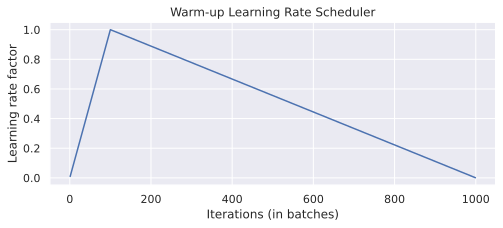

In [11]:
epochs = list(range(1,1000))
scheduler = WarmupScheduler(optimizer, warmup=100, max_iters=1000)
sns.set()
plt.figure(figsize=(8, 3))
plt.plot(epochs, [scheduler.get_lr_factor(e) for e in epochs])
plt.ylabel("Learning rate factor")
plt.xlabel("Iterations (in batches)")
plt.title("Warm-up Learning Rate Scheduler")
plt.show()
sns.reset_orig()

The learning rate factor reaches `1.0` in `100` warm-up steps, and then start decaying towards zero as per the decay policy. 

# Exponential warm-up scheduler

The original transformer paper used an exponential decay scheduler with a warm-up which explicitly uses exponential function i.e.

In [12]:
class ExponentialWarmupScheduler(_LRScheduler):
    def __init__(self, optimizer, warmup):
        self.warmup = warmup
        super().__init__(optimizer)

    def get_lr(self):
        lr_factor = self.get_lr_factor(epoch=self.last_epoch)
        return [base_lr * lr_factor for base_lr in self.base_lrs]

    def get_lr_factor(self, epoch):
      lr_factor = min((epoch + 1)**(-0.5), (epoch + 1) * self.warmup**(-1.5))
      return lr_factor


In [13]:
optimizer = Adam([p], lr=1e-4)

In [14]:
scheduler = ExponentialWarmupScheduler(optimizer, warmup=100)
for epoch in range(10):
    optimizer.step()
    scheduler.step()
    print(f'Epoch {epoch} || LR Factor {scheduler.get_lr_factor(epoch)} || LR {scheduler.get_lr()[0]}')

Epoch 0 || LR Factor 0.001 || LR 2.0000000000000002e-07
Epoch 1 || LR Factor 0.002 || LR 3.0000000000000004e-07
Epoch 2 || LR Factor 0.003 || LR 4.0000000000000003e-07
Epoch 3 || LR Factor 0.004 || LR 5.000000000000001e-07
Epoch 4 || LR Factor 0.005 || LR 6.000000000000001e-07
Epoch 5 || LR Factor 0.006 || LR 7.000000000000001e-07
Epoch 6 || LR Factor 0.007 || LR 8.000000000000001e-07
Epoch 7 || LR Factor 0.008 || LR 9.000000000000002e-07
Epoch 8 || LR Factor 0.009000000000000001 || LR 1.0000000000000002e-06
Epoch 9 || LR Factor 0.01 || LR 1.1e-06


The learning rate factor varies as square-root of the epochs. Looking at the epochs after the warmup. 

In [15]:
scheduler = ExponentialWarmupScheduler(optimizer, warmup=100)
for epoch in range(110):
    optimizer.step()
    scheduler.step()
    if epoch > 99:
      print(f'Epoch {epoch} || LR Factor {scheduler.get_lr_factor(epoch)} || LR {scheduler.get_lr()[0]}')

Epoch 100 || LR Factor 0.09950371902099892 || LR 9.901475429766743e-06
Epoch 101 || LR Factor 0.09901475429766743 || LR 9.853292781642933e-06
Epoch 102 || LR Factor 0.09853292781642932 || LR 9.805806756909202e-06
Epoch 103 || LR Factor 0.09805806756909202 || LR 9.759000729485333e-06
Epoch 104 || LR Factor 0.09759000729485331 || LR 9.712858623572642e-06
Epoch 105 || LR Factor 0.09712858623572641 || LR 9.667364890456637e-06
Epoch 106 || LR Factor 0.09667364890456635 || LR 9.622504486493764e-06
Epoch 107 || LR Factor 0.09622504486493763 || LR 9.578262852211514e-06
Epoch 108 || LR Factor 0.09578262852211514 || LR 9.534625892455924e-06
Epoch 109 || LR Factor 0.09534625892455924 || LR 9.49157995752499e-06


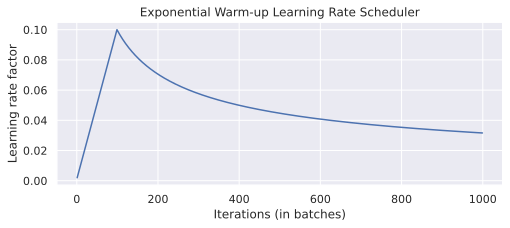

In [16]:
epochs = list(range(1, 1000))
scheduler = ExponentialWarmupScheduler(optimizer, warmup=100)
sns.set()
plt.figure(figsize=(8, 3))
plt.plot(epochs, [scheduler.get_lr_factor(e) for e in epochs])
plt.ylabel("Learning rate factor")
plt.xlabel("Iterations (in batches)")
plt.title("Exponential Warm-up Learning Rate Scheduler")
plt.show()
sns.reset_orig()

# Cosine warm-up scheduler

Currently the most popular scheduler is the cosine warm-up scheduler, which combines warm-up with a cosine-shaped learning rate decay.

In [17]:
import numpy as np

class CosineWarmupScheduler(_LRScheduler):
    def __init__(self, optimizer, warmup, max_iters):
        self.warmup = warmup
        self.max_num_iters = max_iters
        super().__init__(optimizer)

    def get_lr(self):
        lr_factor = self.get_lr_factor(epoch=self.last_epoch)
        return [base_lr * lr_factor for base_lr in self.base_lrs]

    def get_lr_factor(self, epoch):
        lr_factor = 0.5 * (1 + np.cos(np.pi * epoch / self.max_num_iters))
        if epoch <= self.warmup:
            lr_factor = lr_factor * epoch * 1.0 / self.warmup
        return lr_factor


In [18]:
scheduler = CosineWarmupScheduler(optimizer, warmup=100, max_iters=1000)
for epoch in range(10):
    optimizer.step()
    scheduler.step()
    print(f'Epoch {epoch} || LR Factor {scheduler.get_lr_factor(epoch)} || LR {scheduler.get_lr()[0]}')

Epoch 0 || LR Factor 0.0 || LR 9.999975326009293e-07
Epoch 1 || LR Factor 0.009999975326009292 || LR 1.999980260856137e-06
Epoch 2 || LR Factor 0.01999980260856137 || LR 2.999933380663425e-06
Epoch 3 || LR Factor 0.02999933380663425 || LR 3.9998420884076325e-06
Epoch 4 || LR Factor 0.039998420884076326 || LR 4.999691581204152e-06
Epoch 5 || LR Factor 0.04999691581204152 || LR 5.999467057142427e-06
Epoch 6 || LR Factor 0.05999467057142427 || LR 6.999153715529444e-06
Epoch 7 || LR Factor 0.06999153715529444 || LR 7.9987367571332e-06
Epoch 8 || LR Factor 0.079987367571332 || LR 8.998201384426155e-06
Epoch 9 || LR Factor 0.08998201384426154 || LR 9.997532801828659e-06


In [19]:
scheduler = CosineWarmupScheduler(optimizer, warmup=100, max_iters=1000)
for epoch in range(110):
    optimizer.step()
    scheduler.step()
    if epoch > 99:
      print(f'Epoch {epoch} || LR Factor {scheduler.get_lr_factor(epoch)} || LR {scheduler.get_lr()[0]}')

Epoch 100 || LR Factor 0.9755282581475768 || LR 9.750405095503859e-05
Epoch 101 || LR Factor 0.9750405095503858 || LR 9.745480724951473e-05
Epoch 102 || LR Factor 0.9745480724951473 || LR 9.74050951842016e-05
Epoch 103 || LR Factor 0.974050951842016 || LR 9.735491524973721e-05
Epoch 104 || LR Factor 0.9735491524973721 || LR 9.730426794137727e-05
Epoch 105 || LR Factor 0.9730426794137726 || LR 9.725315375899024e-05
Epoch 106 || LR Factor 0.9725315375899024 || LR 9.72015732070525e-05
Epoch 107 || LR Factor 0.9720157320705249 || LR 9.714952679464323e-05
Epoch 108 || LR Factor 0.9714952679464323 || LR 9.709701503543954e-05
Epoch 109 || LR Factor 0.9709701503543953 || LR 9.704403844771128e-05


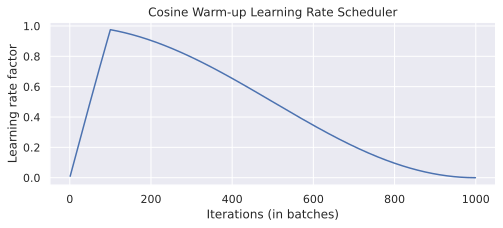

In [20]:
epochs = list(range(1, 1000))
scheduler = CosineWarmupScheduler(optimizer, warmup=100, max_iters=1000)
sns.set()
plt.figure(figsize=(8, 3))
plt.plot(epochs, [scheduler.get_lr_factor(e) for e in epochs])
plt.ylabel("Learning rate factor")
plt.xlabel("Iterations (in batches)")
plt.title("Cosine Warm-up Learning Rate Scheduler")
plt.show()
sns.reset_orig()

This post focussed on warming up the learning process using learning rate schedulers. Next, we will explore the training of transformer models with warm-up schedulers. 